# DeepFool 白盒攻击 Resnet20 网络，分类 CIFAR-10 数据集

### Step1 导入必要库文件，使用 GPU 加速训练 / 推理速度

In [1]:
# 导入必要的库
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from resnet import resnet20  # 本地文件中定义的ResNet-20
from advertorch.attacks.deepfool import DeepfoolLinfAttack
from tqdm.auto import tqdm
import os
import time
import matplotlib.pyplot as plt
import numpy as np

# Matplotlib 设置中文字体显示（可选）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设备配置（CUDA 或 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True


def print_device_info():
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        print(f"使用 GPU 加速: {gpu_name}")
        print(f"CUDA 版本: {torch.version.cuda}")
    else:
        print("未使用 GPU，使用 CPU 执行")

print_device_info()

使用 GPU 加速: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA 版本: 12.4


### Step2 定义 CIFAR-10 的标准化参数，加载测试数据集

In [2]:
# CIFAR-10 图像标准化参数
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD = [0.247, 0.243, 0.261]

# 类别名称列表
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 数据转换与加载
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)  # 设置每批次 100 张图片，最大程度利用 GPU 性能

print(f"数据集加载完成，共 {len(test_set)} 张图像 | Batch数量: {len(test_loader)}")


数据集加载完成，共 10000 张图像 | Batch数量: 100


**说明：**<br>
· 加载 CIFAR-10 测试集，使用 Dataloader 加载数据并分成小批量，每批次 100 张图片，最大化利用 GPU 性能

### Step3 加载预训练的 ResNet-20 模型，验证模型在未攻击下的准确率

In [5]:
model = resnet20()
model = torch.nn.DataParallel(model)  # 支持多GPU
save_path = "./resnet20-12fca82f.th"

try:
    weights_url = "https://github.com/akamaster/pytorch_resnet_cifar10/raw/master/pretrained_models/resnet20-12fca82f.th"
    if not os.path.exists(save_path):
        print("下载预训练权重...")
        torch.hub.download_url_to_file(weights_url, save_path)

    checkpoint = torch.load(save_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint)
    print("预训练权重加载成功")
except Exception as e:
    print(f"权重加载失败: {e}")
    print("使用随机初始化模型继续...")

model.to(device)
model.eval()
print(f"模型加载完成 | 设备: {next(model.parameters()).device}")

total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

base_acc = 100 * total_correct / len(test_set)
print(f"模型原始测试准确率: {base_acc:.2f}%")

if base_acc < 80:
    print("警告: 原始准确率低于预期，建议检查权重文件或预处理一致性")


预训练权重加载成功
模型加载完成 | 设备: cuda:0
模型原始测试准确率: 91.71%


**说明：**<br>
· 下载并加载 CIFAR-10 测试集，导入预训练的 ResNet-20 模型，应用官网定义的权重进行标准化操作<br>
· 输出模型在原始图像上的分类正确率，验证预训练模型导入正常




### Step4 定义保存对抗样本图像的辅助函数

In [8]:
def save_adv_example(orig, adv, label, pred, class_names, save_count):
    """保存对抗样本对比图像"""
    orig = orig.detach().cpu().numpy().transpose(1, 2, 0)
    adv = adv.detach().cpu().numpy().transpose(1, 2, 0)
    perturbation = (adv - orig) * 10 + 0.5  # 扰动增强显示

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    titles = [
        f"Original: {class_names[label]}",
        f"Adversarial: {class_names[pred]}",
        "Perturbation (10x)"
    ]

    for ax, img, title in zip(axs, [orig, adv, perturbation], titles):
        ax.imshow(np.clip(img, 0, 1))
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"adv_examples/example_{save_count}.png", bbox_inches='tight', dpi=150)
    plt.close()

**说明：**<br>
· 将原始图像、对抗图像和扰动图组合成三联图并保存到本地。<br>
· 将扰动放大 10 倍以便于观察

### Step5 初始化 DeepFool 攻击器，执行攻击并保存样本图像

In [9]:
attack = DeepfoolLinfAttack(
    predict=model,
    num_classes=10,
    nb_iter=50,
    eps=10.0 / 255,
    clip_min=0.0,
    clip_max=1.0,
    overshoot=0.1,
    targeted=False
)


os.makedirs("adv_examples", exist_ok=True)

total_correct = 0
adv_correct = 0
successful_attacks = 0
batch_times = []
save_count = 0

start_time = time.time()

for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="攻击进度")):
    batch_start = time.time()
    images, labels = images.to(device), labels.to(device)

    # 原始预测
    with torch.no_grad():
        orig_pred = model(images).argmax(1)
        correct_mask = (orig_pred == labels)
        total_correct += correct_mask.sum().item()

    # 生成对抗样本
    adv_images = attack.perturb(images, labels)

    # 对抗预测
    with torch.no_grad():
        adv_pred = model(adv_images).argmax(1)
        adv_correct += (adv_pred == labels).sum().item()
        successful_attacks += (correct_mask & (adv_pred != labels)).sum().item()

    # 输出首 batch 样本信息
    if batch_idx == 0:
        print("首Batch样本对比:")
        for i in range(min(3, len(images))):
            print(f"样本{i}: 原始={class_names[orig_pred[i]]:9s} | "
                  f"对抗={class_names[adv_pred[i]]:9s} | "
                  f"真实={class_names[labels[i]]}")
        diff = (adv_images - images).abs()
        print("扰动统计:")
        print(f"最大扰动: {diff.max().item() * 255:.2f}/255")
        print(f"平均扰动: {diff.mean().item() * 255:.2f}/255")
        print(f"超过eps的比例: {(diff > (10 / 255)).float().mean().item() * 100:.1f}%")

    # 保存前几组示例图像
    if save_count < 5:
        for i in range(min(5 - save_count, len(images))):
            orig_img = images[i].cpu() * torch.tensor(CIFAR10_STD).view(3, 1, 1) + torch.tensor(CIFAR10_MEAN).view(3, 1, 1)
            adv_img = adv_images[i].cpu() * torch.tensor(CIFAR10_STD).view(3, 1, 1) + torch.tensor(CIFAR10_MEAN).view(3, 1, 1)

            save_adv_example(
                orig_img, adv_img,
                labels[i], adv_pred[i],
                class_names, save_count
            )
            save_count += 1

    batch_time = time.time() - batch_start
    batch_times.append(batch_time)

攻击进度:   0%|          | 0/100 [00:04<?, ?it/s]

首Batch样本对比:
样本0: 原始=cat       | 对抗=airplane  | 真实=cat
样本1: 原始=ship      | 对抗=airplane  | 真实=ship
样本2: 原始=ship      | 对抗=airplane  | 真实=ship
扰动统计:
最大扰动: 507.32/255
平均扰动: 135.64/255
超过eps的比例: 70.4%


**说明：**<br>
· 创建一个 DeepFool 对抗攻击器，基于 L♾️ 范数约束<br>
· 遍历每个测试批次：<br>
&nbsp;&nbsp;· 得到原始分类预测；<br>
&nbsp;&nbsp;· 再次进行分类预测；<br>
&nbsp;&nbsp;· 统计攻击成功数与扰动大小。<br>
· 保存前 5 张攻击图像至本地 adv_examples/文件夹中


### Step6 统计整体攻击结果

In [10]:
total_time = time.time() - start_time
original_acc = 100 * total_correct / len(test_set)
adv_acc = 100 * adv_correct / len(test_set)
attack_success_rate = 100 * successful_attacks / total_correct if total_correct > 0 else 0

print("攻击结果统计:")
print(f"总耗时: {total_time:.2f}s ({total_time / 60:.1f}分钟)")
print(f"原始准确率: {original_acc:.2f}%")
print(f"对抗准确率: {adv_acc:.2f}%")
print(f"攻击成功率: {attack_success_rate:.2f}%")
print(f"平均batch处理时间: {np.mean(batch_times):.2f}s")
print("对抗样本示例已保存至 adv_examples/ 目录")


攻击结果统计:
总耗时: 1006.13s (16.8分钟)
原始准确率: 91.71%
对抗准确率: 4.57%
攻击成功率: 96.85%
平均batch处理时间: 9.62s
对抗样本示例已保存至 adv_examples/ 目录


**说明：**<br>
· 汇总攻击过程的性能指标：<br>
&nbsp;&nbsp;· 攻击后模型准确率；<br>
&nbsp;&nbsp;· 对抗攻击成功率；<br>
&nbsp;&nbsp;· 总运行时间与平均批次处理时间；<br><br>

经实验验证，对抗精度为 4.57%，低于 10% ，满足白盒攻击的实验要求。


### Step7 显示前两组对抗攻击样本图像


显示前两组对抗样本图像：


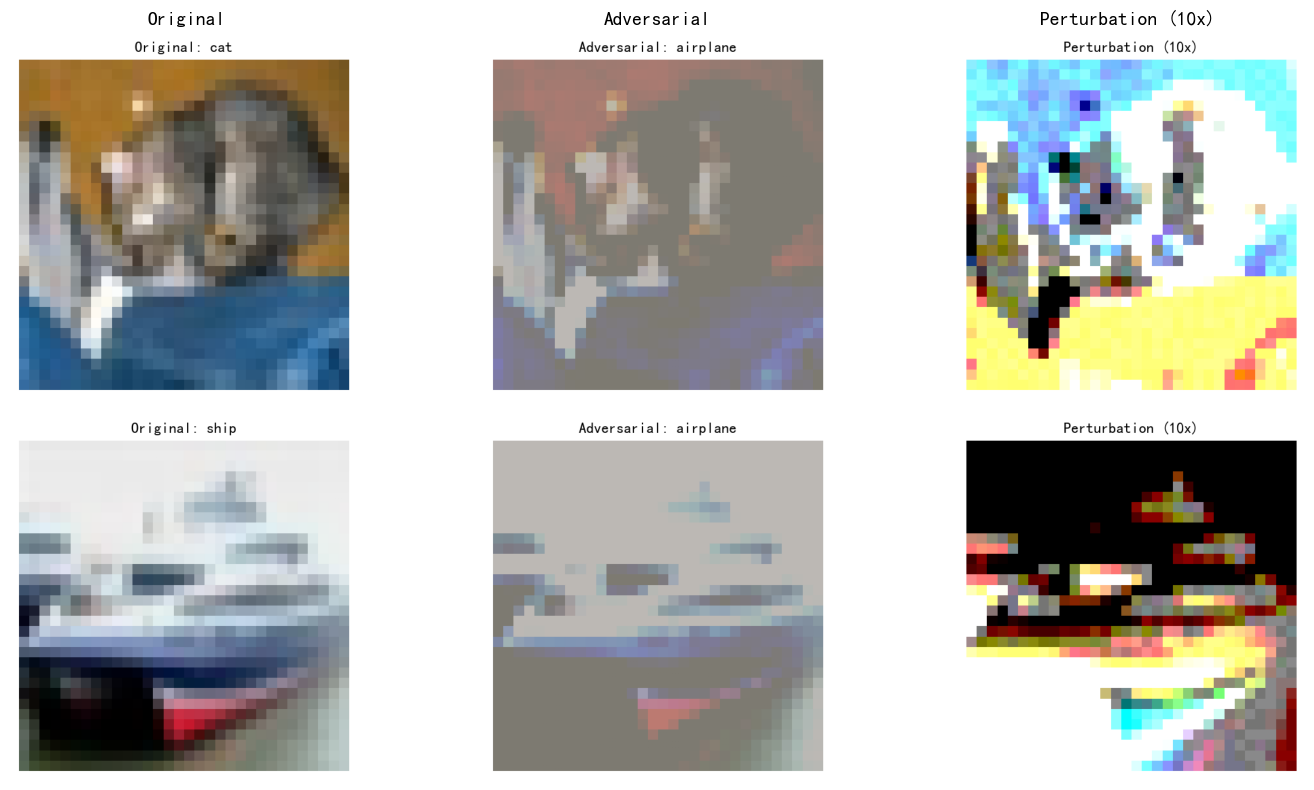

In [12]:
import matplotlib.image as mpimg

def display_saved_examples():
    """
    显示之前保存的前两组对抗样本图像（包含原图、对抗图、扰动图）。
    图像文件为 PNG 格式，位于 adv_examples/ 目录中。
    """
    print("\n显示前两组对抗样本图像：")
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    
    for i in range(2):  # 显示 example_0.png 和 example_1.png
        try:
            # 加载保存的图像
            img = mpimg.imread(f'adv_examples/example_{i}.png')
            
            # 将整张图像分成三个子图（原始图、对抗图、扰动图）
            # 由于我们原来是用 subplot 横向排列的，因此这里将整张图像水平切三份
            height, width, _ = img.shape
            third = width // 3
            
            for j in range(3):
                axs[i, j].imshow(img[:, j * third:(j + 1) * third, :])
                axs[i, j].axis('off')
                
                if i == 0:
                    # 只在第一行显示标题
                    axs[i, j].set_title(["Original", "Adversarial", "Perturbation (10x)"][j], fontsize=14)

        except FileNotFoundError:
            print(f"未找到图像文件 adv_examples/example_{i}.png")

    plt.tight_layout()
    plt.show()

# 在 main 函数末尾调用
display_saved_examples()
